# Load the libraries and define the necessary functions

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme(style="whitegrid", palette="Set2")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D 
from tensorflow.keras.layers import MaxPool2D, Conv2D, Concatenate, GlobalAveragePooling2D, Dropout, GlobalAvgPool2D, MaxPooling2D
from tensorflow.keras.activations import relu


In [2]:
def prepare_dataset(path, size=224, color_mode='grayscale', batch_size=32, augmentation=False):
    # create a dataframe of filepath and labels
    dir = Path(path)
    filepaths = list(dir.glob(r'**/*.*'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='filepath').astype(str)
    labels = pd.Series(labels, name='label')
    df = pd.concat([filepaths , labels] , axis=1)
    
    # split the dataframe on train and test
    train_df, test_df = train_test_split(df, 
                                test_size=0.2, 
                                random_state=0, 
                                stratify=df['label'])
    
    # create data generators
    if augmentation:
        datagen_train = ImageDataGenerator(validation_split = 0.2,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          zoom_range=0.1,
                                          fill_mode='constant',
                                          cval=0,
                                          horizontal_flip=True)
    else:
        datagen_train = ImageDataGenerator(validation_split = 0.2)
    datagen_test = ImageDataGenerator()
    

    train_images = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=(size, size),
        color_mode=color_mode,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='training'
    )


    val_images = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=(size, size),
        color_mode=color_mode,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='validation'
    )


    test_images = datagen_test.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        y_col='label',
        target_size=(size, size),
        color_mode=color_mode,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_images, val_images, test_images

def get_pred_true_labels(model, generator):
    """The function take the keras model instance and the generator and returns
    y_true the true class values
    y_pred the predicted class values
    
    The function set the shuffling of a generator to false, 
    so to turn on shuffling the generator should be reinitialized
    """
    generator.shuffle = False
    generator.index_array = None
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.array(generator.classes)
    return y_true, y_pred

def plot_confusion_matrix(cm, title):
    with sns.axes_style("white"):
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                      display_labels = ['covid', 'normal', 'pneumonia'],)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title(title);

def report_to_df(rep_dict):
    df = pd.DataFrame(rep_dict).reset_index()
    df = df.rename(columns={"index": "metrics"})
    df = df.drop(['accuracy'], axis=1)
    df = pd.melt(df, id_vars=['metrics'], 
        value_vars=['covid', 'normal', 'pneumonia', 'macro avg', 'weighted avg'],
        var_name='label', value_name='value')
    return df[(df.metrics != 'support')]

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Define the models

## Shallow CNN

In [3]:
# CNN model with 2 layers
def CNN2layers(size):
    inputs = keras.Input(shape=(size, size, 1))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# CNN model with 5 layers
def CNN5layers(size):
    inputs = keras.Input(shape=(size, size, 1))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## DenseNet

In [4]:
# DenseNet models
def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None, name=None):
    X = BatchNormalization(axis = 3)(X_input)
    if activation is not None:
        X = Activation(activation)(X)
    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
               padding = padding)(X)
    #X = Dropout(rate=dropout_rate)(X)
    return X


def dense_block(X, filters, repetitions):
    concat_layers = []
    concat_layers.append(X)

    for _ in range(repetitions):
        Y = conv2d_bn(X, filters=4*filters, kernel_size=(1, 1), strides=1, activation='relu')
        Y = conv2d_bn(Y, filters=filters, kernel_size=(3, 3), strides=1, activation='relu')
        concat_layers.append(Y)
        X = Concatenate()(concat_layers)

    return X

def transition_layer(X_input):
    in_channel = X_input.shape[-1] // 2
    X = conv2d_bn(X_input, filters=in_channel, kernel_size=(1, 1), strides=1, activation='relu')
    #X = Dropout(rate=dropout_rate)(X)
    X = AveragePooling2D(pool_size=(2, 2), strides=2)(X)
    return X

def DenseNet(input_shape, filters=32, n_classes=1, repetitions=[6, 12, 24, 16]):  
    inputs = Input(input_shape)
    X = layers.Rescaling(1./255)(inputs)
    X = Conv2D(2*filters, kernel_size=(7, 7), strides=2, padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(X)
    
    for i in range(len(repetitions)-1):
        repetition = repetitions[i]
        X = dense_block(X, filters, repetition)
        X = transition_layer(X)
    repetition = repetitions[i+1]
    X = dense_block(X, filters, repetition)
        
    X = BatchNormalization(axis = 3)(X)
    X = GlobalAveragePooling2D()(X)
    if n_classes == 1:
        outputs = Dense(n_classes, activation = 'sigmoid')(X)
    else:
        outputs = Dense(n_classes, activation = 'softmax')(X)
    
    model = Model(inputs, outputs)
    return model

def DenseNetAttention(input_shape, filters=32, n_classes=1, repetitions=[6, 12, 24, 16]):
    def attention_block(g, l):
        N, W, H, C = l.shape
        c = layers.Conv2D(filters=1, kernel_size=(1,1), use_bias=False)(g + l)
        c = layers.Reshape((-1, 1))(c)
        a = tf.nn.softmax(c, axis=1)
        a = layers.Reshape((W, H, 1))(a)
        g = tf.multiply(a, l)
        g = layers.Reshape((-1, C))(g)
        g = tf.reduce_sum(g, axis=1)
        return g
    
    inputs = Input(input_shape)
    X = layers.Rescaling(1./255)(inputs)
    X = Conv2D(2*filters, kernel_size=(7, 7), strides=2, padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(X)
    attention_layers = []
    
    for repetition in repetitions:
        X = dense_block(X, filters, repetition)
        X = transition_layer(X)
        attention_layers.append(X)
        
    X = BatchNormalization(axis = 3)(X)
    X = Conv2D(filters=512, kernel_size=3)(X)
    
    # apply attention
    attention_results = []
    for i in range(3):
        Y = attention_layers[i]
        if Y.shape[3] != 512:
            X_small = Conv2D(filters=Y.shape[3], kernel_size=3, padding="same")(X)
            Y = attention_block(X_small, Y)
        else:
            Y = attention_block(X, Y)

        attention_results.append(Y)
        
    X = Concatenate()(attention_results)
    
    if n_classes == 1:
        outputs = Dense(n_classes, activation = 'sigmoid')(X)
    else:
        outputs = Dense(n_classes, activation = 'softmax')(X)
    
    model = Model(inputs, outputs)
    return model

## ResNet

In [5]:
def resnet(size= 224, num_classes=3):
    def identity_block(X, kernel_size, num_channels):    

        C1, C2 = num_channels
        X_shortcut = X

        X = Conv2D(filters = C1, kernel_size = 1, strides = 1, padding = 'valid')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X = Conv2D(filters = C1, kernel_size = kernel_size, strides = 1, padding = 'same')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X = Conv2D(filters = C2, kernel_size = 1, strides = 1, padding = 'valid')(X)
        X = BatchNormalization(axis = 3)(X)

        X = layers.add(inputs=[X, X_shortcut])
        X = Activation('relu')(X)

        return X

    def convolutional_block(X, kernel_size, num_channels, stride = 2):

        C1, C2 = num_channels

        X_shortcut = X


        X = Conv2D(C1, 1, strides = stride)(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X = Conv2D(C1, kernel_size, strides = 1, padding = 'same')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X = Conv2D(C2, 1, strides = 1, padding = 'same')(X)
        X = BatchNormalization(axis = 3)(X)

        X_shortcut = Conv2D(C2, 1, strides = stride)(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

        X = layers.add(inputs=[X, X_shortcut])
        X = Activation('relu')(X)

        return X
    
    X_input = Input((size,size,1))
    X = layers.Rescaling(1./255)(X_input) 
    X = ZeroPadding2D((3, 3))(X)
    
    X = Conv2D(64, 7, strides = 3)(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(3, strides= 2)(X)

    X = convolutional_block(X, 3, [64, 128], stride = 1)
    X = identity_block(X, 3, [64, 128])

    X = convolutional_block(X, 3,[128, 256], stride = 2)
    X = identity_block(X, 3, [128, 256])
    # X = convolutional_block(X, 3,[128, 128, 256], stride = 2)
    
    X = AveragePooling2D(pool_size=2)(X)

    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    return Model(inputs = X_input, outputs = X)

In [6]:
# define the default training parameters
learning_rate = 1e-4
epochs = 20
patience = 3

# the CustomEarlyStopping class was copied from TensorFlow v2.11.0 as  the 
# version of TensorFlow on Kaggle does not supper the start_from_epoch parameter 
class CustomEarlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
        monitor="val_loss",
        min_delta=0,
        patience=0,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0,
    ):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.start_from_epoch = start_from_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None or epoch < self.start_from_epoch:
            # If no monitor value exists or still in initial warm-up stage.
            return
        if self.restore_best_weights and self.best_weights is None:
            # Restore the weights after first epoch if no progress is ever made.
            self.best_weights = self.model.get_weights()

        self.wait += 1
        if self._is_improvement(current, self.best):
            self.best = current
            self.best_epoch = epoch
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
            # Only restart wait if we beat both the baseline and our previous
            # best.
            if self.baseline is None or self._is_improvement(
                current, self.baseline
            ):
                self.wait = 0
            return

        # Only check after the first epoch.
        if self.wait >= self.patience and epoch > 0:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                if self.verbose > 0:
                    io_utils.print_msg(
                        "Restoring model weights from "
                        "the end of the best epoch: "
                        f"{self.best_epoch + 1}."
                    )
                self.model.set_weights(self.best_weights)
                

def run_experiment(model, model_name, train_ds, valid_ds, learning_rate=learning_rate, epochs=epochs, patience=patience, 
                  late_early_stopping=False):
    model.compile(loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy',
             'Precision',
             'Recall',
             tf.keras.metrics.AUC(
                    num_thresholds=200,
                    curve="ROC",
                    summation_method="interpolation",
                    multi_label=False,
                    from_logits=False)])
    if late_early_stopping and model_name == "repvgg-7-layers":
        callbacks = [
            CustomEarlyStopping(
            monitor="val_loss",
            patience=patience,
            start_from_epoch=20
            ),
            keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.h5",
            save_best_only=True,
            save_weights_only=True,
            monitor="val_accuracy")
            ]
    elif late_early_stopping:
        callbacks = [
            CustomEarlyStopping(
            monitor="val_loss",
            patience=patience,
            start_from_epoch=20
            ),
            keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.h5",
            save_best_only=True,
            monitor="val_accuracy")
            ]
    else:
        callbacks = [
            keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            ),
            keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.h5",
            save_best_only=True,
            monitor="val_accuracy")
            ]

    history = model.fit(
                train_ds,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1,
                validation_data=valid_ds)
    return history

In [7]:
# set the parameters of the dataset
size=224
color_mode='grayscale'
batch_size=32
seed = 123

# Call the above function with seed value
set_seeds(seed=seed)

# Experiments

In [8]:
path = "/kaggle/input/hda-resize-the-dataset-2/resized_dataset/"
train_images, val_images, test_images = prepare_dataset(path, size, color_mode, batch_size)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.


## Dataset with resized images
### Shallow CNN - 2 convolution layers

In [9]:
model_name = "CNN2layers_resized"
model = CNN2layers(size)
model.summary()

2023-02-13 08:42:09.638623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 08:42:09.736749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 08:42:09.737591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 256)     73984     
_________________________________________________________________
flatten (Flatten)            (None, 3041536)           0         
_________________________________________________________________
dense (Dense)                (None, 3)                 912461

2023-02-13 08:42:09.739366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 08:42:09.739771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 08:42:09.740851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 08:42:09.741793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [10]:
%%time
history = run_experiment(model, model_name, train_images, val_images)

2023-02-13 08:42:12.698943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-13 08:42:14.564005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


92/92 [==============================] - 33s 271ms/step - loss: 0.8966 - accuracy: 0.7411 - precision: 0.7662 - recall: 0.6960 - auc: 0.8591 - val_loss: 0.4963 - val_accuracy: 0.7678 - val_precision: 0.8146 - val_recall: 0.7145 - val_auc: 0.9330
Epoch 2/20
92/92 [==============================] - 8s 87ms/step - loss: 0.3841 - accuracy: 0.8770 - precision: 0.8936 - recall: 0.8545 - auc: 0.9607 - val_loss: 0.3013 - val_accuracy: 0.8989 - val_precision: 0.9287 - val_recall: 0.8716 - val_auc: 0.9795
Epoch 3/20
92/92 [==============================] - 8s 83ms/step - loss: 0.2753 - accuracy: 0.9170 - precision: 0.9278 - recall: 0.8999 - auc: 0.9790 - val_loss: 0.2425 - val_accuracy: 0.9276 - val_precision: 0.9383 - val_recall: 0.9139 - val_auc: 0.9835
Epoch 4/20
92/92 [==============================] - 8s 82ms/step - loss: 0.2166 - accuracy: 0.9296 - precision: 0.9403 - recall: 0.9191 - auc: 0.9872 - val_loss: 0.2578 - val_accuracy: 0.9098 - val_precision: 0.9205 - val_recall: 0.9016 - val_a

In [11]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 6s 193ms/step - loss: 0.3037 - accuracy: 0.9213 - precision: 0.9232 - recall: 0.9191 - auc: 0.9743


[0.3036632835865021,
 0.9213114976882935,
 0.9231613874435425,
 0.9191256761550903,
 0.9743335843086243]

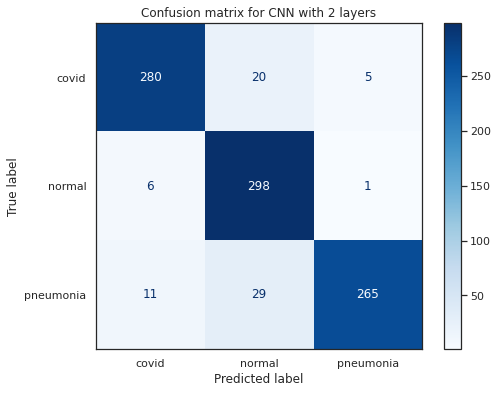

In [12]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 2 layers")

In [13]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)

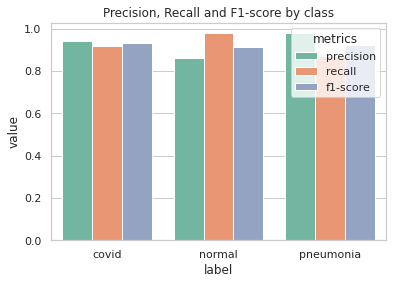

In [14]:
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [15]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

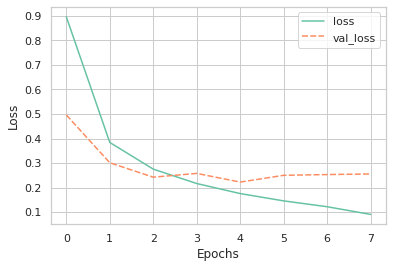

In [16]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

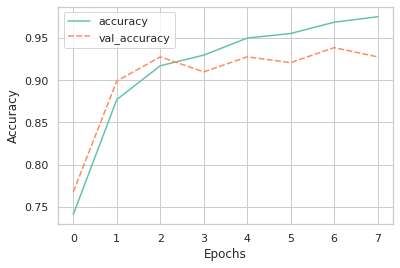

In [17]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### Shallow CNN - 5 layers

In [18]:
model_name = "CNN5layers_resized"
model = CNN5layers(size)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 128)       7385

In [19]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=0.001, epochs=30)

Epoch 1/30
92/92 [==============================] - 9s 86ms/step - loss: 0.7643 - accuracy: 0.6670 - precision: 0.7933 - recall: 0.5242 - auc_1: 0.8452 - val_loss: 0.4650 - val_accuracy: 0.8333 - val_precision: 0.8496 - val_recall: 0.8101 - val_auc_1: 0.9422
Epoch 2/30
92/92 [==============================] - 7s 73ms/step - loss: 0.4738 - accuracy: 0.8398 - precision: 0.8626 - recall: 0.8060 - auc_1: 0.9419 - val_loss: 0.3426 - val_accuracy: 0.8825 - val_precision: 0.8906 - val_recall: 0.8675 - val_auc_1: 0.9674
Epoch 3/30
92/92 [==============================] - 7s 72ms/step - loss: 0.3662 - accuracy: 0.8811 - precision: 0.8963 - recall: 0.8586 - auc_1: 0.9641 - val_loss: 0.2615 - val_accuracy: 0.9139 - val_precision: 0.9186 - val_recall: 0.9098 - val_auc_1: 0.9792
Epoch 4/30
92/92 [==============================] - 7s 74ms/step - loss: 0.3055 - accuracy: 0.9006 - precision: 0.9137 - recall: 0.8893 - auc_1: 0.9739 - val_loss: 0.3636 - val_accuracy: 0.8907 - val_precision: 0.9091 - val

In [20]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 2s 61ms/step - loss: 0.2483 - accuracy: 0.9213 - precision: 0.9272 - recall: 0.9180 - auc_1: 0.9824


[0.248280331492424,
 0.9213114976882935,
 0.9271523356437683,
 0.9180327653884888,
 0.9823858141899109]

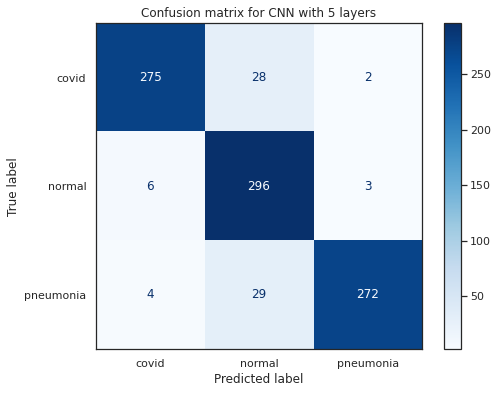

In [21]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 5 layers")

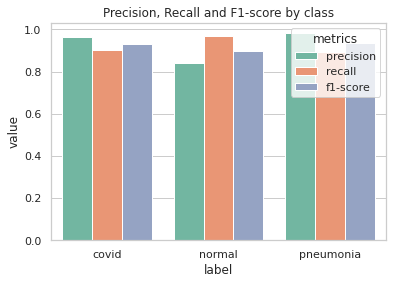

In [22]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [23]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

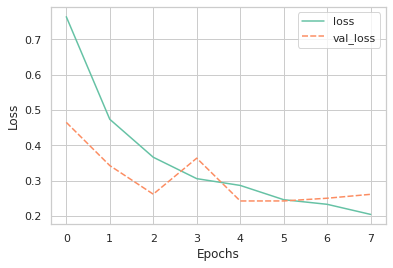

In [24]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

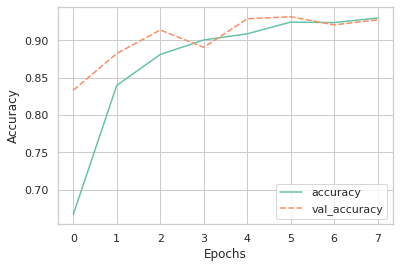

In [25]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-121

In [26]:
model_name = 'DenseNet121_resized'
model = DenseNet((224, 224, 1), n_classes=3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 112, 112, 64) 3200        rescaling_2[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d_7[0][0]                   
____________________________________________________________________________________________

In [27]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 39s 259ms/step - loss: 0.9996 - accuracy: 0.5215 - precision: 0.7681 - recall: 0.1120 - auc_2: 0.6999 - val_loss: 1.1183 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_2: 0.5234
Epoch 2/150
92/92 [==============================] - 20s 218ms/step - loss: 0.8474 - accuracy: 0.6670 - precision: 0.8190 - recall: 0.3893 - auc_2: 0.8317 - val_loss: 1.2826 - val_accuracy: 0.3279 - val_precision: 0.3279 - val_recall: 0.3279 - val_auc_2: 0.5590
Epoch 3/150
92/92 [==============================] - 20s 212ms/step - loss: 0.7602 - accuracy: 0.7179 - precision: 0.8218 - recall: 0.5451 - auc_2: 0.8707 - val_loss: 1.0943 - val_accuracy: 0.4235 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_2: 0.5610
Epoch 4/150
92/92 [==============================] - 20s 217ms/step - loss: 0.7030 - accuracy: 0.7357 - precision: 0.8223 - recall: 0.5956 - auc_2: 0.8903 - val_loss: 1.2585 - val_accuracy: 0.2336 -

In [28]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 7s 111ms/step - loss: 0.2110 - accuracy: 0.9322 - precision: 0.9392 - recall: 0.9290 - auc_2: 0.9854


[0.21099740266799927,
 0.9322404265403748,
 0.939226508140564,
 0.9289617538452148,
 0.9854148626327515]

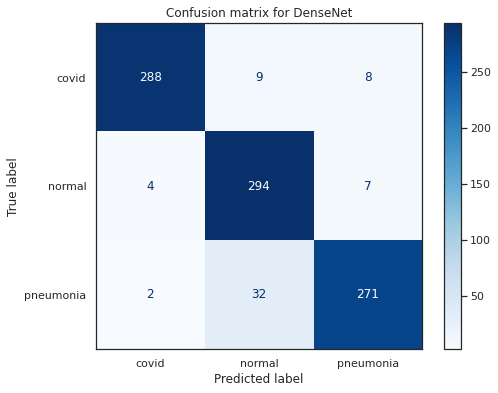

In [29]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet")

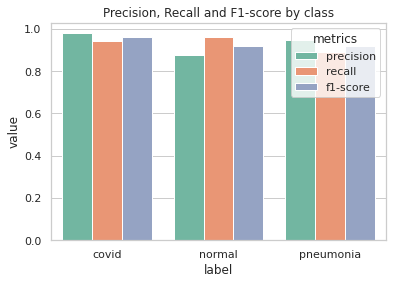

In [30]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [31]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

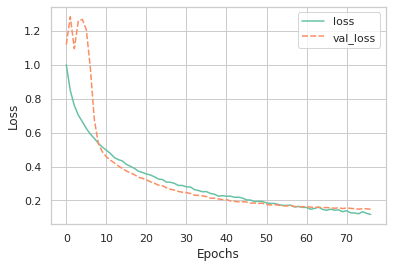

In [32]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

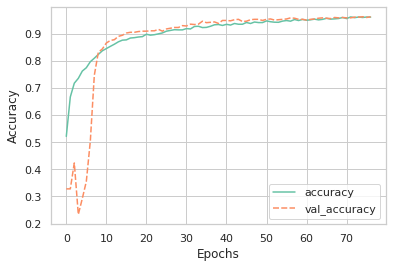

In [33]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-201

In [34]:
model_name = 'DenseNet201_resized'
model = DenseNet((224, 224, 1), n_classes=3, repetitions=[6, 12, 48, 32])

In [35]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 62s 393ms/step - loss: 0.9711 - accuracy: 0.5755 - precision: 0.7589 - recall: 0.2042 - auc_3: 0.7462 - val_loss: 1.1070 - val_accuracy: 0.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_3: 0.5313
Epoch 2/150
92/92 [==============================] - 30s 328ms/step - loss: 0.7742 - accuracy: 0.7005 - precision: 0.8362 - recall: 0.5229 - auc_3: 0.8643 - val_loss: 1.1414 - val_accuracy: 0.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_3: 0.5177
Epoch 3/150
92/92 [==============================] - 30s 330ms/step - loss: 0.6952 - accuracy: 0.7442 - precision: 0.8317 - recall: 0.6195 - auc_3: 0.8898 - val_loss: 1.1391 - val_accuracy: 0.3634 - val_precision: 0.8182 - val_recall: 0.0123 - val_auc_3: 0.5837
Epoch 4/150
92/92 [==============================] - 30s 328ms/step - loss: 0.6453 - accuracy: 0.7678 - precision: 0.8446 - recall: 0.6609 - auc_3: 0.9053 - val_loss: 1.1400 - val_accuracy: 0.2732 -

In [36]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 8s 123ms/step - loss: 0.2104 - accuracy: 0.9344 - precision: 0.9433 - recall: 0.9268 - auc_3: 0.9866


[0.21041159331798553,
 0.9344262480735779,
 0.9432703256607056,
 0.9267759323120117,
 0.9865859746932983]

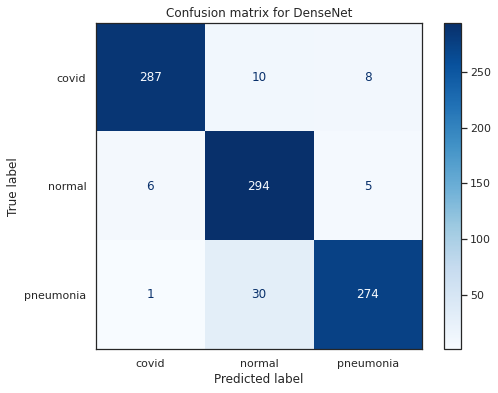

In [37]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet")

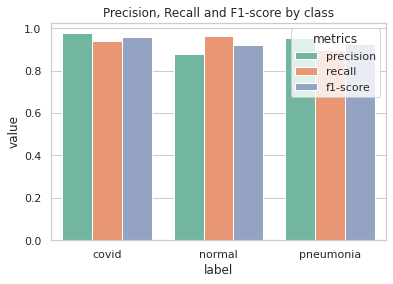

In [38]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [39]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

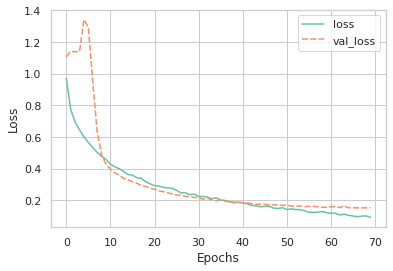

In [40]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

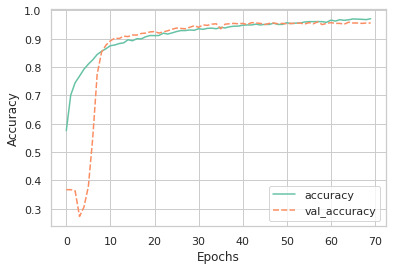

In [41]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet with attention

In [42]:
model_name = "DenseNetAttention_resized"
model = DenseNetAttention((224, 224, 1), n_classes=3)

In [43]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 39s 258ms/step - loss: 1.0666 - accuracy: 0.5338 - precision: 0.4839 - recall: 0.0874 - auc_4: 0.6717 - val_loss: 1.1120 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_4: 0.4792
Epoch 2/150
92/92 [==============================] - 21s 223ms/step - loss: 0.9243 - accuracy: 0.6363 - precision: 0.7628 - recall: 0.1834 - auc_4: 0.7778 - val_loss: 1.1318 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_4: 0.5236
Epoch 3/150
92/92 [==============================] - 21s 224ms/step - loss: 0.8629 - accuracy: 0.6783 - precision: 0.7904 - recall: 0.3193 - auc_4: 0.8140 - val_loss: 1.1364 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_4: 0.5463
Epoch 4/150
92/92 [==============================] - 21s 226ms/step - loss: 0.8048 - accuracy: 0.6892 - precision: 0.7996 - recall: 0.4580 - auc_4: 0.8365 - val_loss: 1.1364 - val_accuracy: 

In [44]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 8s 100ms/step - loss: 0.3800 - accuracy: 0.8852 - precision: 0.9049 - recall: 0.8634 - auc_4: 0.9628


[0.3799854815006256,
 0.8852459192276001,
 0.904925525188446,
 0.8633880019187927,
 0.9628021717071533]

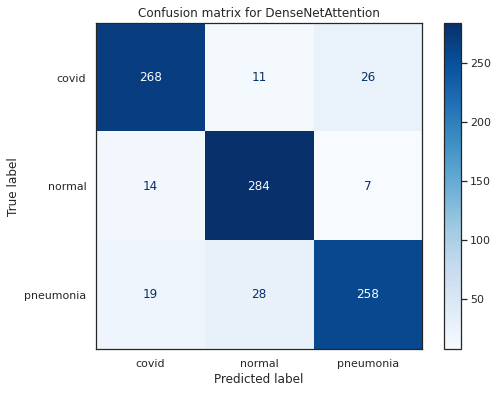

In [45]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNetAttention")

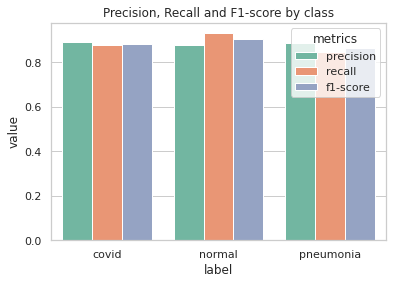

In [46]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [47]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

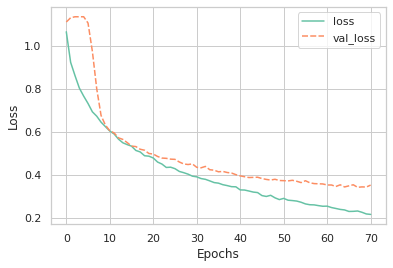

In [48]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

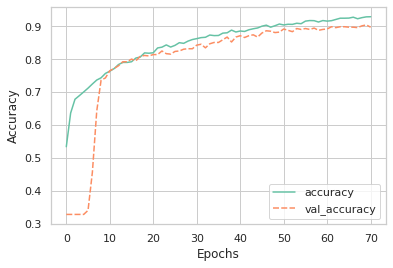

In [49]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### ResNet

In [50]:
model_name="ResNet_resized"
model = resnet(size = 224, num_classes= 3)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 1)  0           input_6[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0           rescaling_5[0][0]                
__________________________________________________________________________________________________
conv2d_454 (Conv2D)             (None, 75, 75, 64)   3200        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [51]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-5, epochs=60, late_early_stopping=True)

Epoch 1/60
92/92 [==============================] - 10s 84ms/step - loss: 0.7966 - accuracy: 0.6667 - precision: 0.7353 - recall: 0.5683 - auc_5: 0.8280 - val_loss: 1.1018 - val_accuracy: 0.3497 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_5: 0.5561
Epoch 2/60


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


92/92 [==============================] - 7s 78ms/step - loss: 0.4609 - accuracy: 0.8548 - precision: 0.8821 - recall: 0.8125 - auc_5: 0.9467 - val_loss: 1.1528 - val_accuracy: 0.3893 - val_precision: 0.4492 - val_recall: 0.2172 - val_auc_5: 0.5810
Epoch 3/60
92/92 [==============================] - 7s 78ms/step - loss: 0.3781 - accuracy: 0.8846 - precision: 0.9029 - recall: 0.8545 - auc_5: 0.9636 - val_loss: 1.2418 - val_accuracy: 0.3934 - val_precision: 0.4127 - val_recall: 0.3648 - val_auc_5: 0.5803
Epoch 4/60
92/92 [==============================] - 8s 84ms/step - loss: 0.3233 - accuracy: 0.9064 - precision: 0.9218 - recall: 0.8859 - auc_5: 0.9724 - val_loss: 1.3373 - val_accuracy: 0.3675 - val_precision: 0.3726 - val_recall: 0.3675 - val_auc_5: 0.6196
Epoch 5/60
92/92 [==============================] - 7s 76ms/step - loss: 0.2837 - accuracy: 0.9214 - precision: 0.9320 - recall: 0.9033 - auc_5: 0.9791 - val_loss: 1.3553 - val_accuracy: 0.3880 - val_precision: 0.3894 - val_recall: 0.

In [52]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 2s 60ms/step - loss: 0.2326 - accuracy: 0.9333 - precision: 0.9401 - recall: 0.9268 - auc_5: 0.9824


[0.23264963924884796,
 0.9333333373069763,
 0.9401330351829529,
 0.9267759323120117,
 0.9823952913284302]

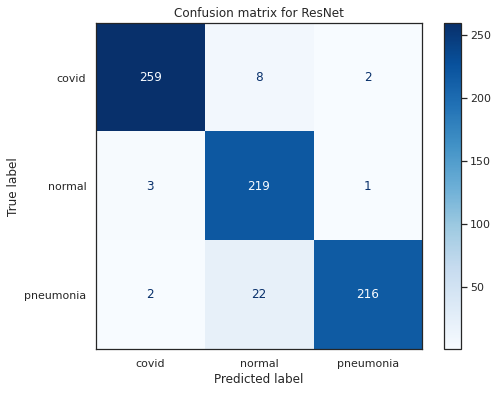

In [53]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for ResNet")

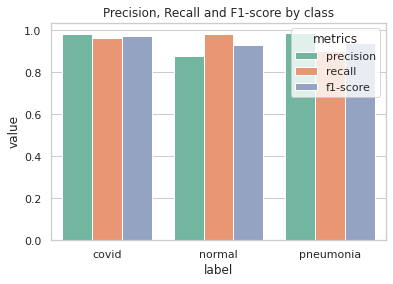

In [54]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

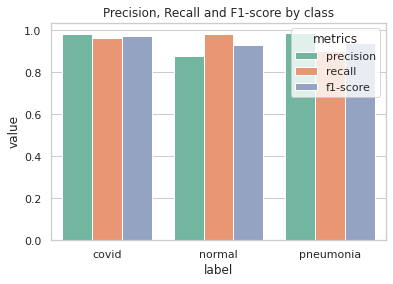

In [55]:
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [56]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

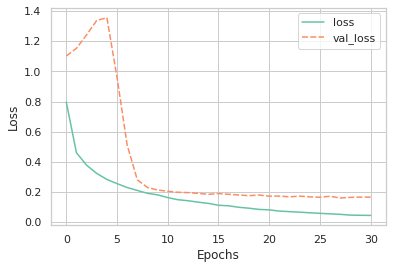

In [57]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

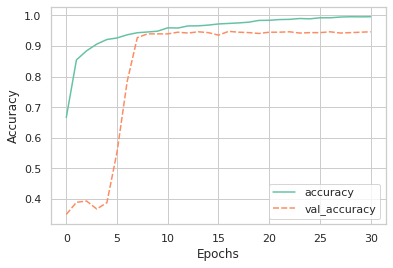

In [58]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

## Dataset with padded images

In [59]:
path = "/kaggle/input/hda-resize-the-dataset-2/resized_with_ratio/"
train_images, val_images, test_images = prepare_dataset(path, size, color_mode, batch_size)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.


### Shallow CNN 2 layers

In [60]:
model_name="CNN2layers_padded"
model = CNN2layers(size)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 109, 109, 256)     73984     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3041536)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 9124

In [61]:
%%time
history = run_experiment(model, model_name, train_images, val_images)

Epoch 1/20
92/92 [==============================] - 24s 252ms/step - loss: 0.6656 - accuracy: 0.7637 - precision: 0.7822 - recall: 0.7336 - auc_6: 0.8960 - val_loss: 0.3339 - val_accuracy: 0.8825 - val_precision: 0.9021 - val_recall: 0.8689 - val_auc_6: 0.9736
Epoch 2/20
92/92 [==============================] - 9s 93ms/step - loss: 0.3354 - accuracy: 0.8941 - precision: 0.9054 - recall: 0.8829 - auc_6: 0.9686 - val_loss: 0.2947 - val_accuracy: 0.9085 - val_precision: 0.9207 - val_recall: 0.8880 - val_auc_6: 0.9817
Epoch 3/20
92/92 [==============================] - 7s 80ms/step - loss: 0.2532 - accuracy: 0.9208 - precision: 0.9297 - recall: 0.9119 - auc_6: 0.9816 - val_loss: 0.2244 - val_accuracy: 0.9331 - val_precision: 0.9389 - val_recall: 0.9235 - val_auc_6: 0.9853
Epoch 4/20
92/92 [==============================] - 7s 79ms/step - loss: 0.2172 - accuracy: 0.9307 - precision: 0.9359 - recall: 0.9225 - auc_6: 0.9867 - val_loss: 0.2523 - val_accuracy: 0.9016 - val_precision: 0.9170 - v

In [62]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 6s 189ms/step - loss: 0.2495 - accuracy: 0.9268 - precision: 0.9308 - recall: 0.9257 - auc_6: 0.9799


[0.24954503774642944,
 0.9267759323120117,
 0.9307692050933838,
 0.9256830811500549,
 0.9798939824104309]

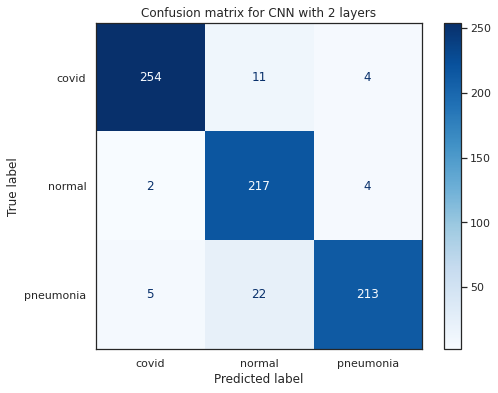

In [63]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 2 layers")

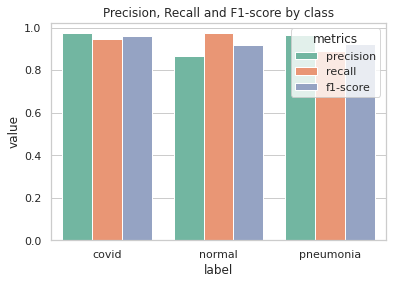

In [64]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

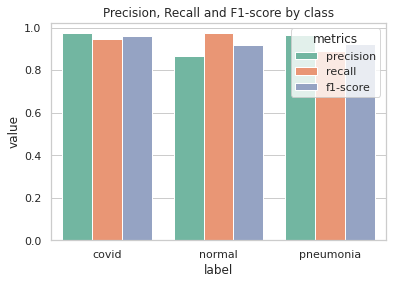

In [65]:
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [66]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

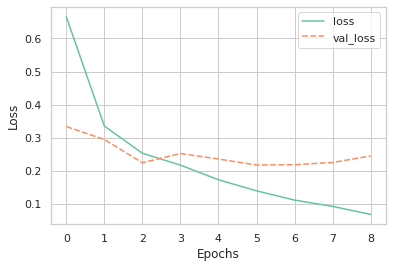

In [67]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

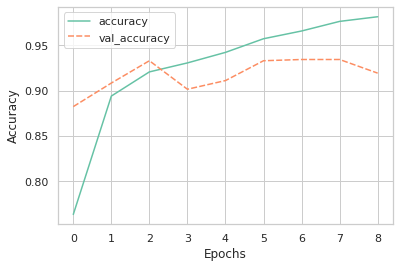

In [68]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### Shallow CNN - 5 layers

In [69]:
model_name = "CNN5layers_padded"
model = CNN5layers(size)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_471 (Conv2D)          (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_472 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_473 (Conv2D)          (None, 52, 52, 128)       7385

In [70]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=0.001, epochs=30)

Epoch 1/30
92/92 [==============================] - 8s 78ms/step - loss: 0.7334 - accuracy: 0.6796 - precision: 0.7407 - recall: 0.5738 - auc_7: 0.8539 - val_loss: 0.6056 - val_accuracy: 0.7896 - val_precision: 0.8377 - val_recall: 0.6066 - val_auc_7: 0.9205
Epoch 2/30
92/92 [==============================] - 6s 69ms/step - loss: 0.5542 - accuracy: 0.7961 - precision: 0.8211 - recall: 0.7524 - auc_7: 0.9204 - val_loss: 0.4857 - val_accuracy: 0.8169 - val_precision: 0.8207 - val_recall: 0.8128 - val_auc_7: 0.9417
Epoch 3/30
92/92 [==============================] - 7s 71ms/step - loss: 0.4378 - accuracy: 0.8586 - precision: 0.8721 - recall: 0.8245 - auc_7: 0.9490 - val_loss: 0.3461 - val_accuracy: 0.8784 - val_precision: 0.8898 - val_recall: 0.8607 - val_auc_7: 0.9669
Epoch 4/30
92/92 [==============================] - 7s 74ms/step - loss: 0.3606 - accuracy: 0.8801 - precision: 0.8951 - recall: 0.8658 - auc_7: 0.9637 - val_loss: 0.3091 - val_accuracy: 0.8948 - val_precision: 0.9083 - val

In [71]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

In [72]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 2s 54ms/step - loss: 0.2564 - accuracy: 0.9246 - precision: 0.9275 - recall: 0.9224 - auc_7: 0.9830


[0.25644707679748535,
 0.9245901703834534,
 0.9274725317955017,
 0.9224043488502502,
 0.9830370545387268]

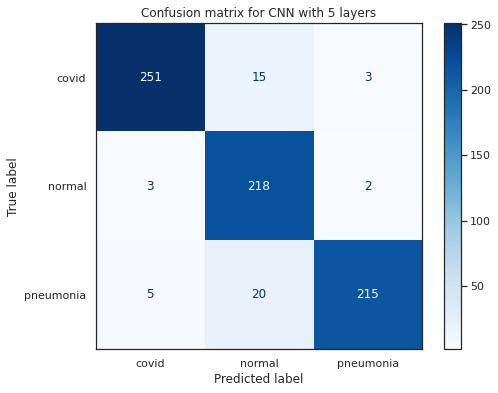

In [73]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 5 layers")

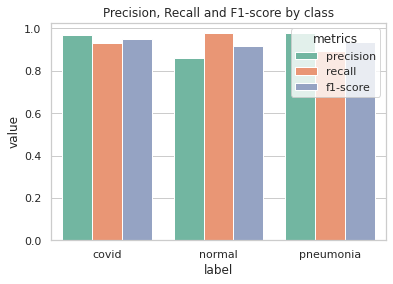

In [74]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

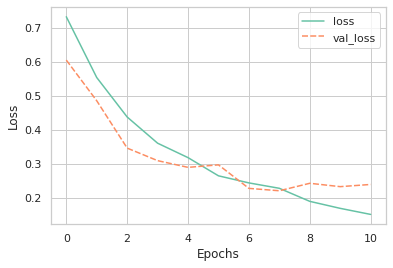

In [75]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

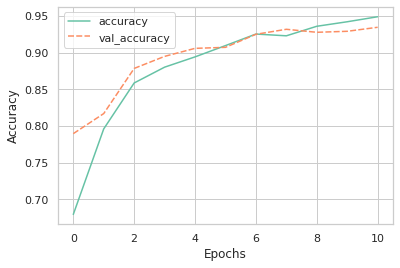

In [76]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-121

In [77]:
model_name = 'DenseNet121_padded'
model = DenseNet((224, 224, 1), n_classes=3)

In [78]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 37s 250ms/step - loss: 0.9302 - accuracy: 0.5936 - precision: 0.7774 - recall: 0.2206 - auc_8: 0.7793 - val_loss: 1.1112 - val_accuracy: 0.3046 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_8: 0.4804
Epoch 2/150
92/92 [==============================] - 20s 215ms/step - loss: 0.7324 - accuracy: 0.7268 - precision: 0.8055 - recall: 0.5615 - auc_8: 0.8818 - val_loss: 1.2464 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_8: 0.5466
Epoch 3/150
92/92 [==============================] - 20s 217ms/step - loss: 0.6460 - accuracy: 0.7585 - precision: 0.8177 - recall: 0.6588 - auc_8: 0.9046 - val_loss: 1.3975 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_8: 0.4808
Epoch 4/150
92/92 [==============================] - 20s 217ms/step - loss: 0.5952 - accuracy: 0.7831 - precision: 0.8298 - recall: 0.7042 - auc_8: 0.9163 - val_loss: 1.5505 - val_accuracy: 0.3292 - val_pre

In [79]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 5s 95ms/step - loss: 0.2138 - accuracy: 0.9344 - precision: 0.9379 - recall: 0.9246 - auc_8: 0.9862


[0.21378766000270844,
 0.9344262480735779,
 0.9379157423973083,
 0.9245901703834534,
 0.986222505569458]

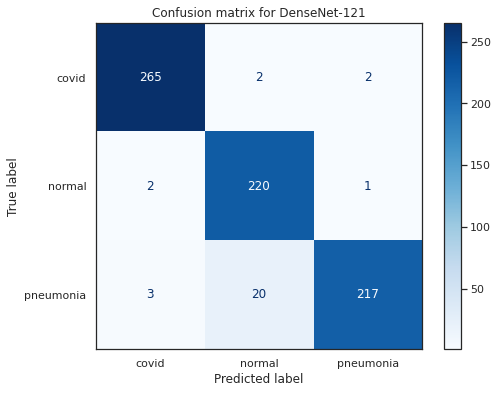

In [80]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet-121")

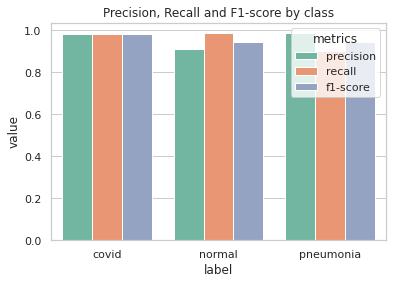

In [81]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [82]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

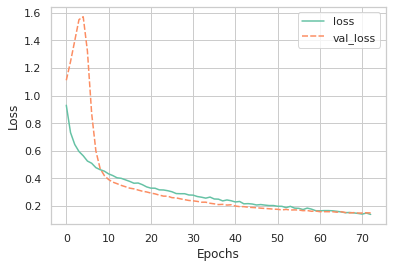

In [83]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

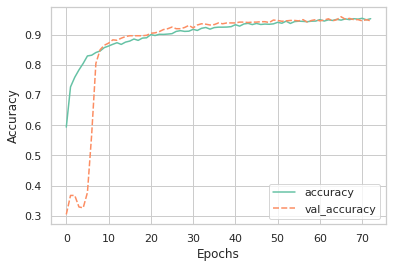

In [84]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-201

In [85]:
model_name = 'DenseNet201_padded'
model = DenseNet((224, 224, 1), n_classes=3, repetitions=[6, 12, 48, 32])

In [86]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 59s 387ms/step - loss: 0.8627 - accuracy: 0.6387 - precision: 0.7632 - recall: 0.3402 - auc_9: 0.8166 - val_loss: 1.1826 - val_accuracy: 0.3046 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_9: 0.4641
Epoch 2/150
92/92 [==============================] - 31s 332ms/step - loss: 0.6799 - accuracy: 0.7302 - precision: 0.7778 - recall: 0.6311 - auc_9: 0.8873 - val_loss: 1.2984 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_9: 0.5096
Epoch 3/150
92/92 [==============================] - 31s 334ms/step - loss: 0.6077 - accuracy: 0.7739 - precision: 0.8155 - recall: 0.6974 - auc_9: 0.9096 - val_loss: 1.6867 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_9: 0.5177
Epoch 4/150
92/92 [==============================] - 31s 333ms/step - loss: 0.5556 - accuracy: 0.8043 - precision: 0.8420 - recall: 0.7408 - auc_9: 0.9242 - val_loss: 1.5265 - val_accuracy: 0.3306 - val_pre

In [87]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 7s 105ms/step - loss: 0.2048 - accuracy: 0.9410 - precision: 0.9440 - recall: 0.9388 - auc_9: 0.9863


[0.2047649472951889,
 0.9409835934638977,
 0.9439560174942017,
 0.9387978315353394,
 0.986348032951355]

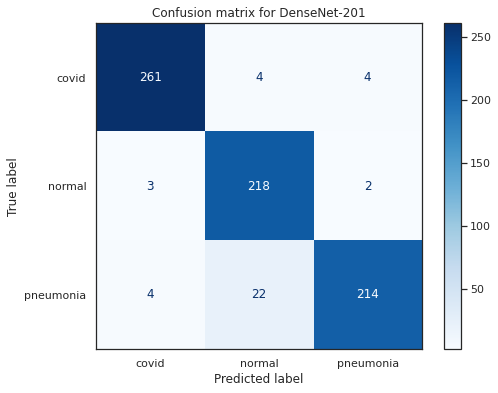

In [88]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet-201")

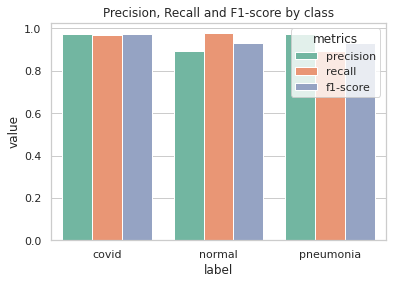

In [89]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [90]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

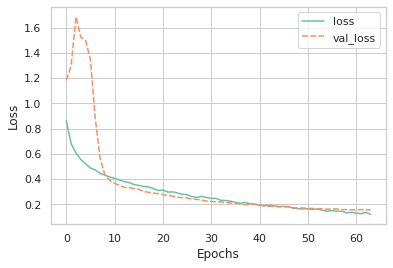

In [91]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

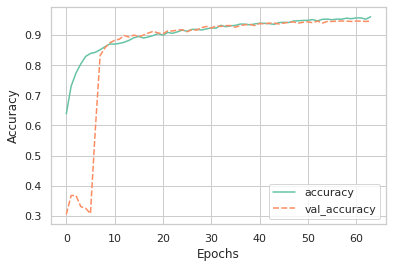

In [92]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet with attention

In [93]:
model_name = "DenseNetAttention_padded"
model = DenseNetAttention((224, 224, 1), n_classes=3)

In [94]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 38s 256ms/step - loss: 1.0655 - accuracy: 0.4426 - precision: 0.5127 - recall: 0.1236 - auc_10: 0.6333 - val_loss: 1.0981 - val_accuracy: 0.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_10: 0.5168
Epoch 2/150
92/92 [==============================] - 21s 223ms/step - loss: 0.8237 - accuracy: 0.7135 - precision: 0.7864 - recall: 0.4037 - auc_10: 0.8450 - val_loss: 1.1315 - val_accuracy: 0.3675 - val_precision: 0.3333 - val_recall: 0.0014 - val_auc_10: 0.5166
Epoch 3/150
92/92 [==============================] - 21s 224ms/step - loss: 0.6897 - accuracy: 0.7674 - precision: 0.8153 - recall: 0.6165 - auc_10: 0.8865 - val_loss: 1.1901 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_10: 0.4769
Epoch 4/150
92/92 [==============================] - 21s 230ms/step - loss: 0.6205 - accuracy: 0.7828 - precision: 0.8265 - recall: 0.6933 - auc_10: 0.9039 - val_loss: 1.2570 - val_accuracy: 0.3675 - 

In [95]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 5s 95ms/step - loss: 0.3497 - accuracy: 0.8940 - precision: 0.8981 - recall: 0.8863 - auc_10: 0.9658


[0.34966781735420227,
 0.893989086151123,
 0.8981173634529114,
 0.8863387703895569,
 0.9658398628234863]

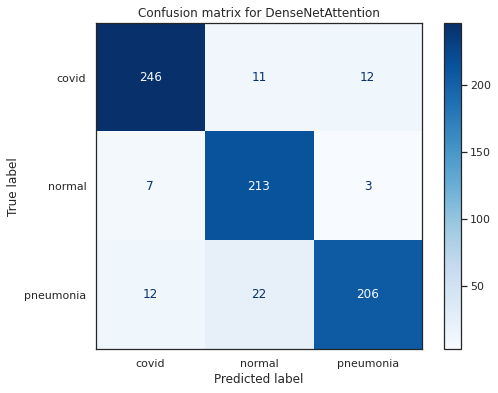

In [96]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNetAttention")

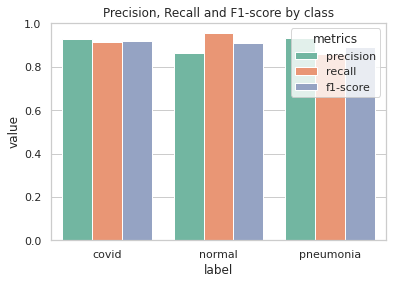

In [97]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [98]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

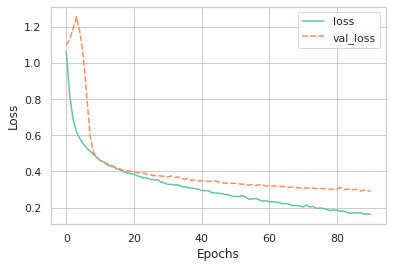

In [99]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

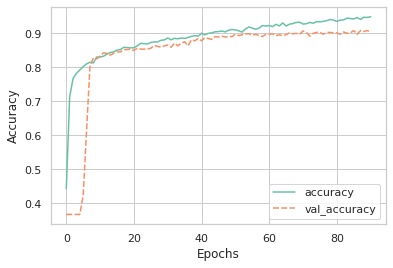

In [100]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### ResNet

In [101]:
model_name="ResNet_padded"
model = resnet(size = 224, num_classes= 3)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 224, 224, 1)  0           input_12[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 1)  0           rescaling_11[0][0]               
__________________________________________________________________________________________________
conv2d_923 (Conv2D)             (None, 75, 75, 64)   3200        zero_padding2d_1[0][0]           
___________________________________________________________________________________________

In [102]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-5, epochs=100, late_early_stopping=True)

Epoch 1/100
92/92 [==============================] - 10s 84ms/step - loss: 0.7612 - accuracy: 0.6889 - precision: 0.7329 - recall: 0.6212 - auc_11: 0.8457 - val_loss: 1.1271 - val_accuracy: 0.3046 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_11: 0.4988
Epoch 2/100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


92/92 [==============================] - 7s 76ms/step - loss: 0.4437 - accuracy: 0.8480 - precision: 0.8697 - recall: 0.8227 - auc_11: 0.9477 - val_loss: 1.3511 - val_accuracy: 0.3675 - val_precision: 0.3680 - val_recall: 0.3675 - val_auc_11: 0.5556
Epoch 3/100
92/92 [==============================] - 7s 74ms/step - loss: 0.3627 - accuracy: 0.8777 - precision: 0.8907 - recall: 0.8624 - auc_11: 0.9649 - val_loss: 1.7583 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_11: 0.5703
Epoch 4/100
92/92 [==============================] - 7s 74ms/step - loss: 0.3131 - accuracy: 0.8989 - precision: 0.9133 - recall: 0.8846 - auc_11: 0.9745 - val_loss: 1.5615 - val_accuracy: 0.3675 - val_precision: 0.3676 - val_recall: 0.3661 - val_auc_11: 0.6074
Epoch 5/100
92/92 [==============================] - 7s 77ms/step - loss: 0.2709 - accuracy: 0.9187 - precision: 0.9303 - recall: 0.9078 - auc_11: 0.9805 - val_loss: 1.3960 - val_accuracy: 0.3770 - val_precision: 0.3760 - val_

In [103]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 3s 85ms/step - loss: 0.2072 - accuracy: 0.9290 - precision: 0.9338 - recall: 0.9257 - auc_11: 0.9875


[0.20720452070236206,
 0.9289617538452148,
 0.9338478446006775,
 0.9256830811500549,
 0.9875357747077942]

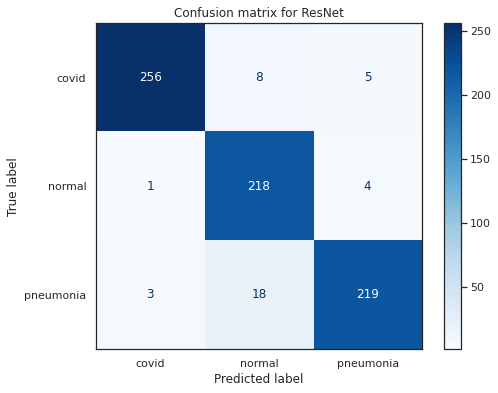

In [104]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for ResNet")

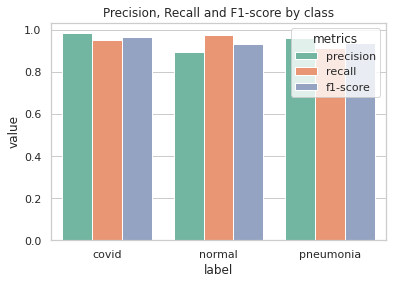

In [105]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [106]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

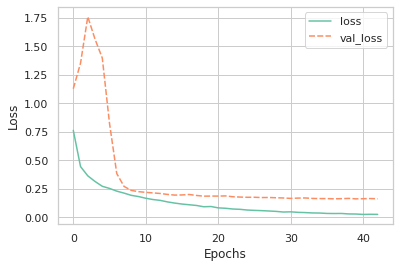

In [107]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

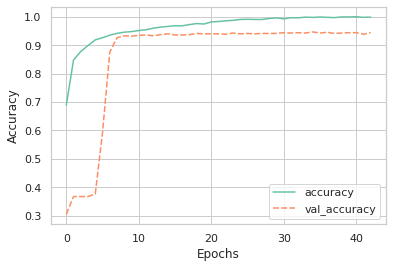

In [108]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

## Dataset with center cropped images

In [109]:
path = "/kaggle/input/hda-resize-the-dataset-2/resized_center_crop/"
train_images, val_images, test_images = prepare_dataset(path, size, color_mode, batch_size)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.


### CNN 2 layers

In [110]:
model_name = "CNN2layers_center_crop"
model = CNN2layers(size)
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_938 (Conv2D)          (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_939 (Conv2D)          (None, 109, 109, 256)     73984     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3041536)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 912

In [111]:
%%time
history = run_experiment(model, model_name, train_images, val_images)

Epoch 1/20
92/92 [==============================] - 25s 263ms/step - loss: 0.9283 - accuracy: 0.6930 - precision: 0.7306 - recall: 0.6168 - auc_12: 0.8178 - val_loss: 0.4414 - val_accuracy: 0.8484 - val_precision: 0.8737 - val_recall: 0.8033 - val_auc_12: 0.9487
Epoch 2/20
92/92 [==============================] - 9s 95ms/step - loss: 0.4034 - accuracy: 0.8624 - precision: 0.8842 - recall: 0.8395 - auc_12: 0.9559 - val_loss: 0.3737 - val_accuracy: 0.8607 - val_precision: 0.8866 - val_recall: 0.8333 - val_auc_12: 0.9636
Epoch 3/20
92/92 [==============================] - 8s 87ms/step - loss: 0.2944 - accuracy: 0.9085 - precision: 0.9213 - recall: 0.8880 - auc_12: 0.9762 - val_loss: 0.3240 - val_accuracy: 0.8975 - val_precision: 0.9062 - val_recall: 0.8839 - val_auc_12: 0.9677
Epoch 4/20
92/92 [==============================] - 8s 83ms/step - loss: 0.2410 - accuracy: 0.9221 - precision: 0.9336 - recall: 0.9126 - auc_12: 0.9839 - val_loss: 0.2806 - val_accuracy: 0.9085 - val_precision: 0.9

In [112]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 6s 199ms/step - loss: 0.3194 - accuracy: 0.9049 - precision: 0.9131 - recall: 0.8962 - auc_12: 0.9731


[0.3194241225719452,
 0.9049180150032043,
 0.9131402969360352,
 0.8961748480796814,
 0.9731240272521973]

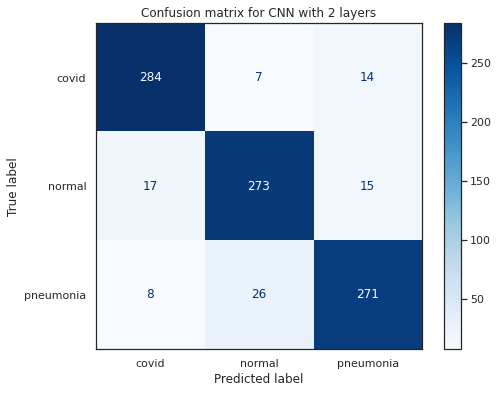

In [113]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 2 layers")

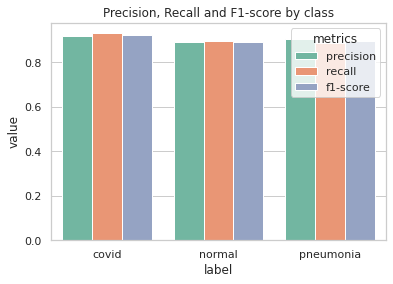

In [114]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [115]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

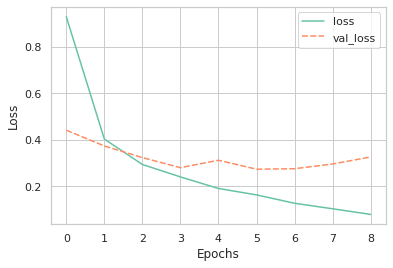

In [116]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

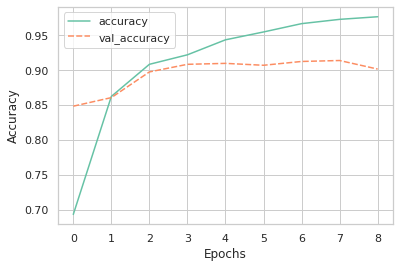

In [117]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### CNN 5 layers

In [118]:
model_name = "CNN5layers_center_crop"
model = CNN5layers(size)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_13 (Rescaling)     (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_940 (Conv2D)          (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_941 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_942 (Conv2D)          (None, 52, 52, 128)       738

In [119]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=0.001, epochs=30)

Epoch 1/30
92/92 [==============================] - 9s 82ms/step - loss: 0.9572 - accuracy: 0.5891 - precision: 0.7100 - recall: 0.2650 - auc_13: 0.7465 - val_loss: 0.8059 - val_accuracy: 0.7336 - val_precision: 0.8436 - val_recall: 0.3757 - val_auc_13: 0.8637
Epoch 2/30
92/92 [==============================] - 7s 79ms/step - loss: 0.6614 - accuracy: 0.7541 - precision: 0.8039 - recall: 0.6749 - auc_13: 0.8894 - val_loss: 0.4325 - val_accuracy: 0.8429 - val_precision: 0.8789 - val_recall: 0.8033 - val_auc_13: 0.9547
Epoch 3/30
92/92 [==============================] - 7s 72ms/step - loss: 0.4195 - accuracy: 0.8617 - precision: 0.8848 - recall: 0.8391 - auc_13: 0.9522 - val_loss: 0.3284 - val_accuracy: 0.9016 - val_precision: 0.9097 - val_recall: 0.8811 - val_auc_13: 0.9702
Epoch 4/30
92/92 [==============================] - 7s 76ms/step - loss: 0.3395 - accuracy: 0.8880 - precision: 0.9013 - recall: 0.8702 - auc_13: 0.9671 - val_loss: 0.2914 - val_accuracy: 0.9180 - val_precision: 0.927

In [120]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 2s 59ms/step - loss: 0.2308 - accuracy: 0.9399 - precision: 0.9436 - recall: 0.9333 - auc_13: 0.9827


[0.2308414876461029,
 0.9398906826972961,
 0.9436464309692383,
 0.9333333373069763,
 0.9827172756195068]

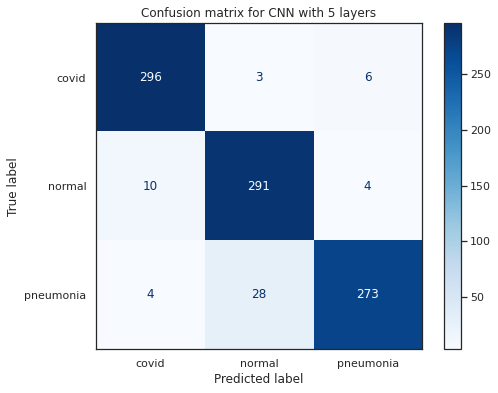

In [121]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 5 layers")

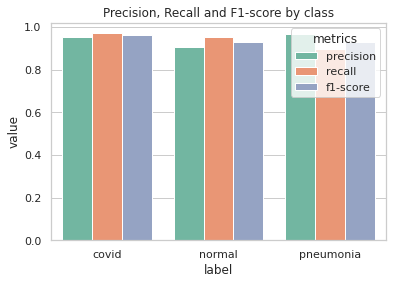

In [122]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [123]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

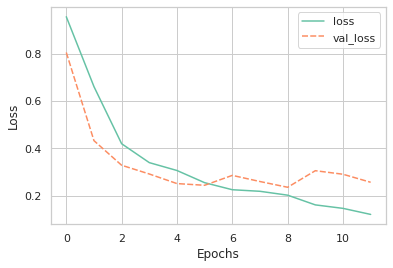

In [124]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

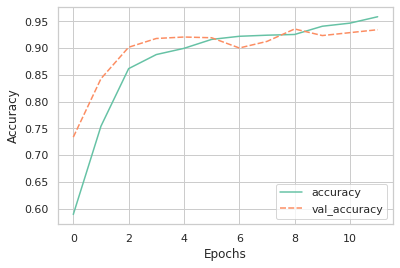

In [125]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-121

In [126]:
model_name = 'DenseNet121_center_crop'
model = DenseNet((224, 224, 1), n_classes=3)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
rescaling_14 (Rescaling)        (None, 224, 224, 1)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_945 (Conv2D)             (None, 112, 112, 64) 3200        rescaling_14[0][0]               
__________________________________________________________________________________________________
batch_normalization_918 (BatchN (None, 112, 112, 64) 256         conv2d_945[0][0]                 
___________________________________________________________________________________________

In [127]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 38s 257ms/step - loss: 0.9166 - accuracy: 0.6168 - precision: 0.7500 - recall: 0.2992 - auc_14: 0.7800 - val_loss: 1.1395 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_14: 0.4818
Epoch 2/150
92/92 [==============================] - 20s 218ms/step - loss: 0.7656 - accuracy: 0.7077 - precision: 0.7915 - recall: 0.5639 - auc_14: 0.8572 - val_loss: 1.1178 - val_accuracy: 0.3279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_14: 0.4813
Epoch 3/150
92/92 [==============================] - 20s 221ms/step - loss: 0.7025 - accuracy: 0.7264 - precision: 0.8063 - recall: 0.6311 - auc_14: 0.8785 - val_loss: 1.2134 - val_accuracy: 0.3279 - val_precision: 0.3511 - val_recall: 0.3142 - val_auc_14: 0.5555
Epoch 4/150
92/92 [==============================] - 20s 215ms/step - loss: 0.6624 - accuracy: 0.7442 - precision: 0.8161 - recall: 0.6670 - auc_14: 0.8925 - val_loss: 1.3049 - val_accuracy: 0

In [128]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 6s 97ms/step - loss: 0.2416 - accuracy: 0.9322 - precision: 0.9371 - recall: 0.9279 - auc_14: 0.9816


[0.24158750474452972,
 0.9322404265403748,
 0.9370861053466797,
 0.9278688430786133,
 0.9815751910209656]

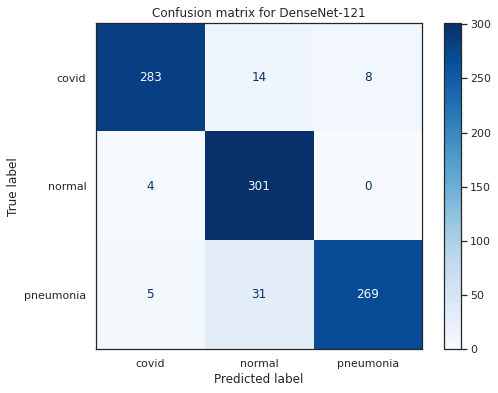

In [129]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet-121")

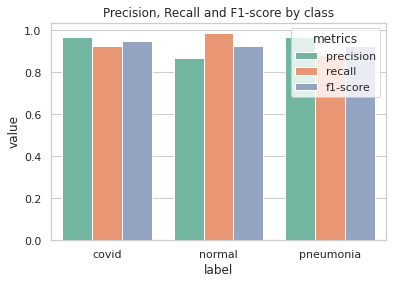

In [130]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [131]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

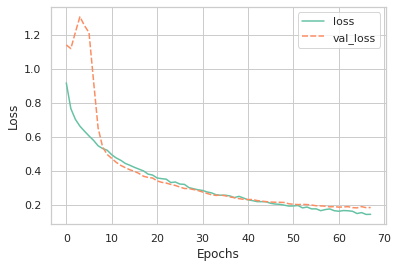

In [132]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

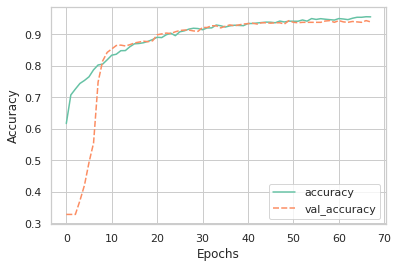

In [133]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-201

In [134]:
model_name = 'DenseNet201_center_crop'
model = DenseNet((224, 224, 1), n_classes=3, repetitions=[6, 12, 48, 32])

In [135]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 61s 386ms/step - loss: 0.9347 - accuracy: 0.5529 - precision: 0.6955 - recall: 0.2886 - auc_15: 0.7462 - val_loss: 1.1819 - val_accuracy: 0.3279 - val_precision: 0.3279 - val_recall: 0.3279 - val_auc_15: 0.5170
Epoch 2/150
92/92 [==============================] - 31s 337ms/step - loss: 0.7747 - accuracy: 0.6653 - precision: 0.7399 - recall: 0.5577 - auc_15: 0.8438 - val_loss: 1.4746 - val_accuracy: 0.3279 - val_precision: 0.3279 - val_recall: 0.3279 - val_auc_15: 0.5245
Epoch 3/150
92/92 [==============================] - 31s 337ms/step - loss: 0.7126 - accuracy: 0.7053 - precision: 0.7781 - recall: 0.6240 - auc_15: 0.8703 - val_loss: 1.6178 - val_accuracy: 0.3279 - val_precision: 0.3279 - val_recall: 0.3279 - val_auc_15: 0.5559
Epoch 4/150
92/92 [==============================] - 31s 339ms/step - loss: 0.6636 - accuracy: 0.7281 - precision: 0.8029 - recall: 0.6523 - auc_15: 0.8913 - val_loss: 1.5465 - val_accuracy: 0.3279 - val_prec

In [136]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 8s 109ms/step - loss: 0.2229 - accuracy: 0.9355 - precision: 0.9382 - recall: 0.9290 - auc_15: 0.9851


[0.2229434847831726,
 0.9355190992355347,
 0.9381898641586304,
 0.9289617538452148,
 0.9850860834121704]

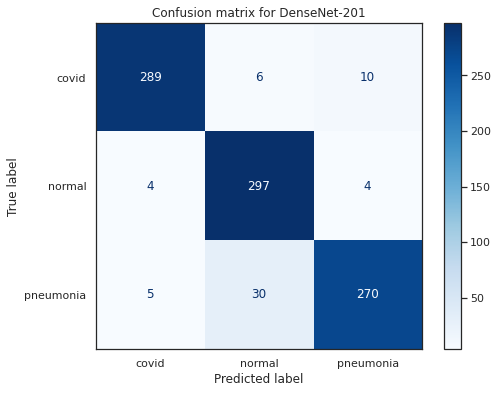

In [137]:
y_true, y_pred = get_pred_true_labels(model, test_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet-201")

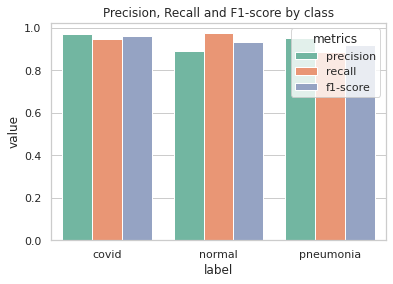

In [138]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [139]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

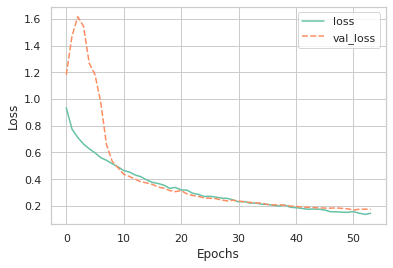

In [140]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

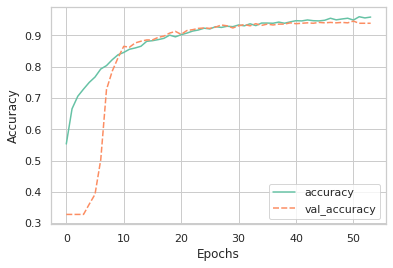

In [141]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

## Using Data Augmentation

In [142]:
path = "/kaggle/input/hda-resize-the-dataset-2/resized_with_ratio/"
train_images, val_images, test_images = prepare_dataset(path, size, color_mode, batch_size, augmentation=True)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.


### Shallow CNN with 2 layers

In [143]:
model_name = "CNN2layers_aug"
model = CNN2layers(size)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_16 (Rescaling)     (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1265 (Conv2D)         (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1266 (Conv2D)         (None, 109, 109, 256)     73984     
_________________________________________________________________
flatten_8 (Flatten)          (None, 3041536)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 912

In [144]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-3)

Epoch 1/20
92/92 [==============================] - 20s 211ms/step - loss: 1.4700 - accuracy: 0.5516 - precision: 0.6415 - recall: 0.3948 - auc_16: 0.7485 - val_loss: 0.7747 - val_accuracy: 0.6134 - val_precision: 0.6746 - val_recall: 0.5437 - val_auc_16: 0.8227
Epoch 2/20
92/92 [==============================] - 20s 220ms/step - loss: 0.7444 - accuracy: 0.6533 - precision: 0.7103 - recall: 0.5526 - auc_16: 0.8457 - val_loss: 0.6300 - val_accuracy: 0.7186 - val_precision: 0.7753 - val_recall: 0.6270 - val_auc_16: 0.8908
Epoch 3/20
92/92 [==============================] - 19s 208ms/step - loss: 0.6543 - accuracy: 0.7258 - precision: 0.7613 - recall: 0.6612 - auc_16: 0.8867 - val_loss: 0.6455 - val_accuracy: 0.7186 - val_precision: 0.7611 - val_recall: 0.6530 - val_auc_16: 0.8863
Epoch 4/20
92/92 [==============================] - 21s 224ms/step - loss: 0.5963 - accuracy: 0.7626 - precision: 0.7946 - recall: 0.7227 - auc_16: 0.9083 - val_loss: 0.6152 - val_accuracy: 0.7240 - val_precisio

In [145]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 2s 54ms/step - loss: 0.4330 - accuracy: 0.8470 - precision: 0.8597 - recall: 0.8306 - auc_16: 0.9495


[0.4330494999885559,
 0.8469945192337036,
 0.8597285151481628,
 0.8306010961532593,
 0.9495136141777039]

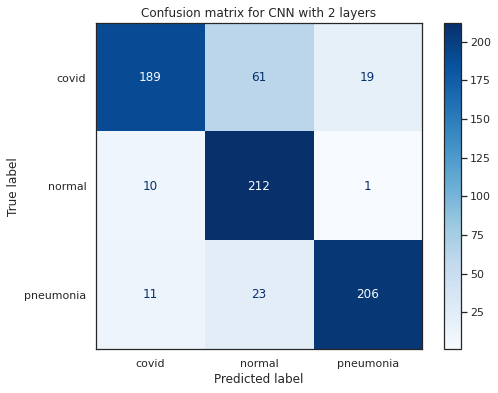

In [146]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 2 layers")

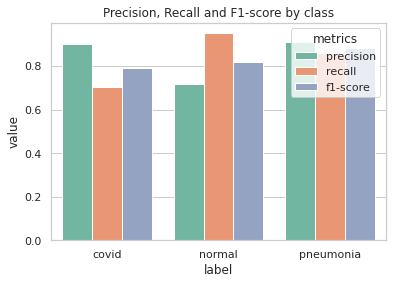

In [147]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)
sns.barplot(data=df_report[(df_report.label != 'macro avg') & (df_report.label != 'weighted avg')], x="label", y="value", hue="metrics")
plt.title("Precision, Recall and F1-score by class");

In [148]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

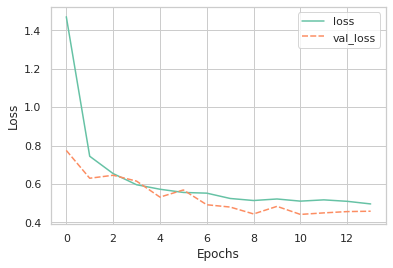

In [149]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

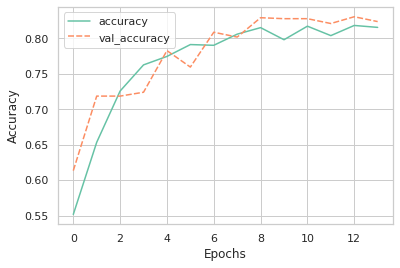

In [150]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### Shallow CNN 5 layers

In [151]:
model_name = "CNN5layers_aug"
model = CNN5layers(size)
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_17 (Rescaling)     (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1267 (Conv2D)         (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1268 (Conv2D)         (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_1269 (Conv2D)         (None, 52, 52, 128)       738

In [152]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=0.001, epochs=30)

Epoch 1/30
92/92 [==============================] - 19s 200ms/step - loss: 0.8808 - accuracy: 0.5598 - precision: 0.6747 - recall: 0.3535 - auc_17: 0.7659 - val_loss: 0.8399 - val_accuracy: 0.6626 - val_precision: 0.8240 - val_recall: 0.3005 - val_auc_17: 0.8332
Epoch 2/30
92/92 [==============================] - 20s 222ms/step - loss: 0.7490 - accuracy: 0.6718 - precision: 0.7266 - recall: 0.5482 - auc_17: 0.8460 - val_loss: 0.6722 - val_accuracy: 0.7077 - val_precision: 0.7405 - val_recall: 0.6667 - val_auc_17: 0.8820
Epoch 3/30
92/92 [==============================] - 18s 191ms/step - loss: 0.6844 - accuracy: 0.7090 - precision: 0.7582 - recall: 0.6393 - auc_17: 0.8768 - val_loss: 0.6203 - val_accuracy: 0.7172 - val_precision: 0.7500 - val_recall: 0.6762 - val_auc_17: 0.8953
Epoch 4/30
92/92 [==============================] - 20s 216ms/step - loss: 0.6304 - accuracy: 0.7428 - precision: 0.7886 - recall: 0.6855 - auc_17: 0.8968 - val_loss: 0.5659 - val_accuracy: 0.7623 - val_precisio

In [153]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 3s 86ms/step - loss: 0.3259 - accuracy: 0.8863 - precision: 0.9025 - recall: 0.8699 - auc_17: 0.9723


[0.32591408491134644,
 0.8863387703895569,
 0.9024943113327026,
 0.8699453473091125,
 0.9722747206687927]

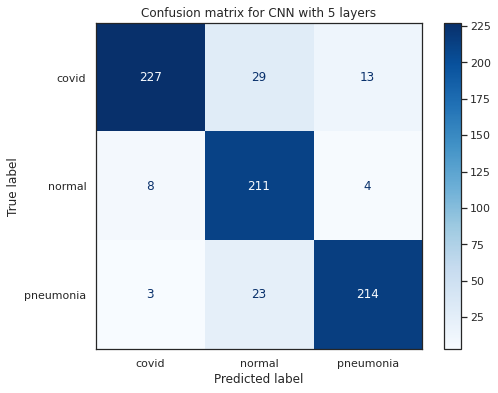

In [154]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for CNN with 5 layers")

In [155]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)

In [156]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

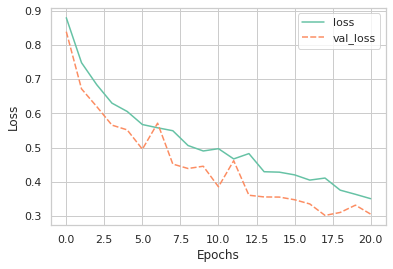

In [157]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

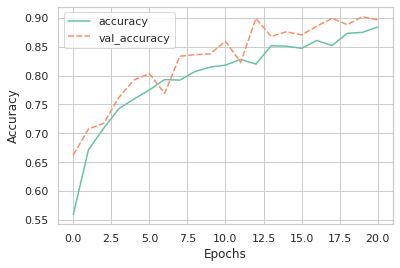

In [158]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

### DenseNet-121

In [159]:
model_name = 'DenseNet121_aug'
model = DenseNet((224, 224, 1), n_classes=3)
# model.summary()

In [160]:
%%time
history = run_experiment(model, model_name, train_images, val_images, learning_rate=1e-6, epochs=150, late_early_stopping=True)

Epoch 1/150
92/92 [==============================] - 44s 317ms/step - loss: 1.0538 - accuracy: 0.4658 - precision: 0.6170 - recall: 0.0919 - auc_18: 0.6323 - val_loss: 1.1020 - val_accuracy: 0.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_18: 0.5219
Epoch 2/150
92/92 [==============================] - 23s 252ms/step - loss: 0.8883 - accuracy: 0.6325 - precision: 0.7711 - recall: 0.3118 - auc_18: 0.8026 - val_loss: 1.1401 - val_accuracy: 0.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc_18: 0.5587
Epoch 3/150
92/92 [==============================] - 27s 287ms/step - loss: 0.8111 - accuracy: 0.6776 - precision: 0.7780 - recall: 0.4368 - auc_18: 0.8415 - val_loss: 1.3776 - val_accuracy: 0.3675 - val_precision: 0.3675 - val_recall: 0.3675 - val_auc_18: 0.5444
Epoch 4/150
92/92 [==============================] - 24s 257ms/step - loss: 0.7636 - accuracy: 0.6919 - precision: 0.7784 - recall: 0.5171 - auc_18: 0.8575 - val_loss: 1.6115 - val_accuracy: 0

In [161]:
model = keras.models.load_model(f"/kaggle/working/{model_name}.h5")
model.evaluate(test_images)

29/29 [==============================] - 6s 92ms/step - loss: 0.3345 - accuracy: 0.9027 - precision: 0.9141 - recall: 0.8842 - auc_18: 0.9705


[0.3345071077346802,
 0.902732253074646,
 0.9141243100166321,
 0.8841530084609985,
 0.9705235362052917]

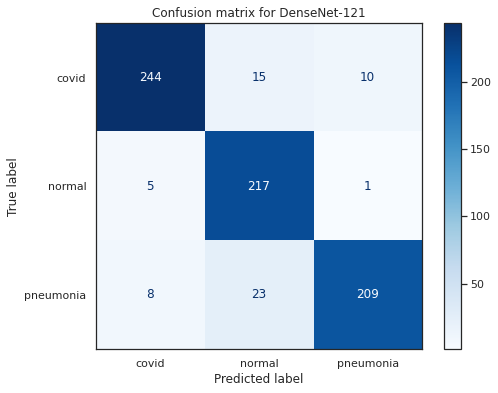

In [162]:
y_true, y_pred = get_pred_true_labels(model, val_images)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, "Confusion matrix for DenseNet-121")

In [163]:
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
df_report = report_to_df(report)

In [164]:
hist_df = pd.DataFrame(history.history)
hist_df['model_name'] = pd.Series([model_name]*len(hist_df))
hist_df.to_csv(f'{model_name}.csv', index=False)

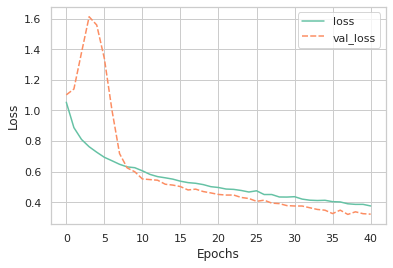

In [165]:
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

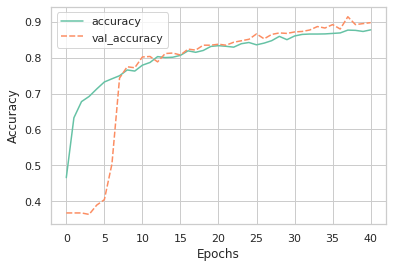

In [166]:
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');